In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
kevinarvai_clinvar_conflicting_path = kagglehub.dataset_download('kevinarvai/clinvar-conflicting')

print('Data source import complete.')


100%|██████████| 3.59M/3.59M [00:01<00:00, 2.97MB/s]

Extracting files...


Data source import complete.


# **Project: Identification of Cancer-Causing Mutations**
*(Dataset Source: ClinVar)*

**Overview** In this project, we address the challenge of distinguishing between **Driver** (cancer-causing) and **Passenger** (neutral) mutations. Due to the restricted access of cancer-specific datasets (like TCGA), we utilize the **ClinVar** public dataset as a proxy, where:
- Pathogenic variants serve as the positive class (analogous to Cancer Drivers).
- Benign variants serve as the negative class (Passenger/Neutral).

**Workflow**
1. Data Cleaning & Preprocessing:
  - Filtered the ClinVar dataset to isolate entries with definitive Pathogenic vs Benign labels.
  - Handled missing values in critical columns and encoded categorical variables (e.g., Amino_acids, Ref, Alt).

2. Exploratory Data Analysis (EDA):
  - Analyzed the distribution of variants across different chromosomes.
  - Addressed Class Imbalance (as neutral mutations often outnumber pathogenic ones) to prevent model bias.

3. Feature Selection:
  - Selected biological features such as Allele Frequency and Molecular Consequence to serve as predictors.

4. Model Building:
  - Trained supervised machine learning models (Logistic Regression, Random Forest, etc.) to classify mutations based on their feature profiles.

**Impact:** This model demonstrates a computational approach to **Prioritizing Cancer Mutations**, helping researchers filter through thousands of genetic variants to identify potential therapeutic targets.

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [ ]:
import os
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

Current working directory: /content


In [ ]:
df = pd.read_csv('/content/clinvar_conflicting.csv', low_memory=False)

In [ ]:
df['CLASS'].value_counts()

,count
CLASS,
0,48754
1,16434


In [ ]:
df.columns

Index(['CHROM', 'POS', 'REF', 'ALT', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'CLNDISDB',
       'CLNDISDBINCL', 'CLNDN', 'CLNDNINCL', 'CLNHGVS', 'CLNSIGINCL', 'CLNVC',
       'CLNVI', 'MC', 'ORIGIN', 'SSR', 'CLASS', 'Allele', 'Consequence',
       'IMPACT', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 'EXON',
       'INTRON', 'cDNA_position', 'CDS_position', 'Protein_position',
       'Amino_acids', 'Codons', 'DISTANCE', 'STRAND', 'BAM_EDIT', 'SIFT',
       'PolyPhen', 'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS',
       'MOTIF_SCORE_CHANGE', 'LoFtool', 'CADD_PHRED', 'CADD_RAW', 'BLOSUM62'],
      dtype='object')

In [ ]:
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

In [ ]:
df.shape

(65188, 46)

## Data Cleaning

The info above indicates that the DataFrame has a total of 46 parameters (fields) that pertain to the genetic mutation samples in the database. We start by examining the variables and begin cleaning the data.

Data cleaning typically involves examining null values, detecting outliers, and visualizing initial relationships between categorical and continuous variables.

In [ ]:
# we are creating new dataframe var_df
var_df = pd.DataFrame(columns=['variable_name', 'data_type', 'missing_percentage', 'flag', 'unique_values_count'])

missing_percentages = df.isnull().mean() * 100
missing_percentages = missing_percentages.sort_values(ascending=False)

for col in df.columns:
    data_type = df[col].dtype
    missing_percentage = missing_percentages[col]
    unique_values_count = df[col].nunique()
    if data_type == 'int64' or data_type == 'float64':
        flag = 'numeric'
    else:
        flag = 'categorical'
    var_df = pd.concat([var_df, pd.DataFrame({'variable_name': [col], 'data_type': [data_type], 'missing_percentage': [missing_percentage], 'flag': [flag], 'unique_values_count': [unique_values_count]})], ignore_index=True)

var_df.info()
var_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   variable_name        46 non-null     object 
 1   data_type            46 non-null     object 
 2   missing_percentage   46 non-null     float64
 3   flag                 46 non-null     object 
 4   unique_values_count  46 non-null     object 
dtypes: float64(1), object(4)
memory usage: 1.9+ KB


/tmp/ipython-input-3974968242.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  var_df = pd.concat([var_df, pd.DataFrame({'variable_name': [col], 'data_type': [data_type], 'missing_percentage': [missing_percentage], 'flag': [flag], 'unique_values_count': [unique_values_count]})], ignore_index=True)


,variable_name,data_type,missing_percentage,flag,unique_values_count
0,CHROM,object,0.000000,categorical,24
1,POS,int64,0.000000,numeric,63115
2,REF,object,0.000000,categorical,866
3,ALT,object,0.000000,categorical,458
4,AF_ESP,float64,0.000000,numeric,2842
5,AF_EXAC,float64,0.000000,numeric,6667
6,AF_TGP,float64,0.000000,numeric,2087
7,CLNDISDB,object,0.000000,categorical,9234
8,CLNDISDBINCL,object,99.743818,categorical,93
9,CLNDN,object,0.000000,categorical,9260


In [ ]:
# sort variables by missing percentage value
var_df_sorted = var_df.sort_values(by='missing_percentage')
var_df_sorted.reset_index(drop=True, inplace=True)

var_df_sorted

,variable_name,data_type,missing_percentage,flag,unique_values_count
0,CHROM,object,0.000000,categorical,24
1,POS,int64,0.000000,numeric,63115
2,REF,object,0.000000,categorical,866
3,ALT,object,0.000000,categorical,458
4,AF_ESP,float64,0.000000,numeric,2842
5,AF_EXAC,float64,0.000000,numeric,6667
6,AF_TGP,float64,0.000000,numeric,2087
7,CLNDISDB,object,0.000000,categorical,9234
8,CLNDN,object,0.000000,categorical,9260
9,CLNHGVS,object,0.000000,categorical,65188


**Dropping Empty Columns** The chart indicates that 9 columns are virtually empty, containing less than 0.5% actual data. To prevent model noise, we implement a cleanup rule: any feature with **>99%** missing values is immediately removed from the dataset.

In [ ]:
var_df = var_df_sorted.copy()

threshold = 99
var_df = var_df[var_df['missing_percentage'] <= threshold]

var_df

,variable_name,data_type,missing_percentage,flag,unique_values_count
0,CHROM,object,0.000000,categorical,24
1,POS,int64,0.000000,numeric,63115
2,REF,object,0.000000,categorical,866
3,ALT,object,0.000000,categorical,458
4,AF_ESP,float64,0.000000,numeric,2842
5,AF_EXAC,float64,0.000000,numeric,6667
6,AF_TGP,float64,0.000000,numeric,2087
7,CLNDISDB,object,0.000000,categorical,9234
8,CLNDN,object,0.000000,categorical,9260
9,CLNHGVS,object,0.000000,categorical,65188


**Now removing the the cols with more that 99% from the dataframe**

In [ ]:
threshold = 99

missing_percentages = df.isnull().mean() * 100
columns_to_drop = missing_percentages[missing_percentages > threshold].index.tolist()

df = df.drop(columns=columns_to_drop)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDISDB          65188 non-null  object 
 8   CLNDN             65188 non-null  object 
 9   CLNHGVS           65188 non-null  object 
 10  CLNVC             65188 non-null  object 
 11  CLNVI             27659 non-null  object 
 12  MC                64342 non-null  object 
 13  ORIGIN            65188 non-null  int64  
 14  CLASS             65188 non-null  int64  
 15  Allele            65188 non-null  object 
 16  Consequence       65188 non-null  object

Lets understand the relationships between variables to better understand inconsistencies and errors in the data. A heat matrix will give us a good initial indication of correlations between **numeric variables**.

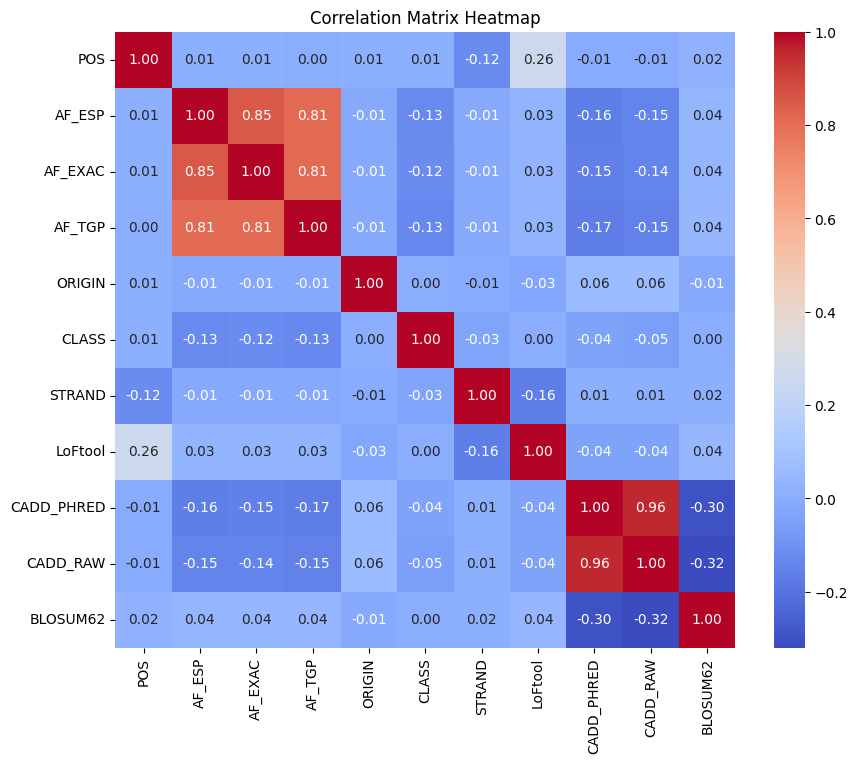

In [ ]:
numerical_columns = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDN,CLNHGVS,...,Amino_acids,Codons,STRAND,BAM_EDIT,SIFT,PolyPhen,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,not_specified,NC_000001.10:g.1168180G>C,...,E/D,gaG/gaC,1.0,NaN,tolerated,benign,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",Spinocerebellar_ataxia_21|not_provided,NC_000001.10:g.1470752G>A,...,P/L,cCg/cTg,-1.0,OK,deleterious_low_confidence,benign,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",Strabismus|Nystagmus|Hypothyroidism|Intellectu...,NC_000001.10:g.1737942A>G,...,I/T,aTc/aCc,-1.0,OK,deleterious,probably_damaging,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",Shprintzen-Goldberg_syndrome|not_provided,NC_000001.10:g.2160305G>A,...,G/S,Ggc/Agc,1.0,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",Shprintzen-Goldberg_syndrome,NC_000001.10:g.2160305G>T,...,G/C,Ggc/Tgc,1.0,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


With respect to this project and experiment, there are several columns amongst the main 'df' dataframe that can be dropped.

1. BAM_EDIT = Binary Map Alignment, indicates whether it's stored in a particular database, not relevant.
2. INTRON = severely low amount of non-null values, contains date
3. EXON = contains dates, not performing time series, not relevant
4. CLNDISB = Provides MedGen database identifiers, not relevant
5. CLNHGVS = provides database identifier, not relevant
6. MC = repeat of Consequence with additional database identifier
7. CLNVI = lab location identifier, not relevant for current project.
8. SYMBOL = another identifier, redundant
9. Feature: Value included in consequence column
10. Feature_type: Value included in consequence column
11. BIOTYPE: Value included in consequence column
12. CADD_RAW: directly related to CADD_PHRED - only CADD_PHRED is needed with respect to genetic mutations, it uses a scale that is easier to work with.

In [ ]:
df.drop(['BAM_EDIT', 'EXON', 'CLNDISDB', 'CLNHGVS',
         'MC', 'CLNVI', 'SYMBOL', 'Feature', 'Feature_type',
         'BIOTYPE', 'INTRON', 'CADD_RAW'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  object 
 8   CLNVC             65188 non-null  object 
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  object 
 12  Consequence       65188 non-null  object 
 13  IMPACT            65188 non-null  object 
 14  cDNA_position     56304 non-null  object 
 15  CDS_position      55233 non-null  object 
 16  Protein_position  55233 non-null  object

In [ ]:
numerical_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   POS         65188 non-null  int64  
 1   AF_ESP      65188 non-null  float64
 2   AF_EXAC     65188 non-null  float64
 3   AF_TGP      65188 non-null  float64
 4   ORIGIN      65188 non-null  int64  
 5   CLASS       65188 non-null  int64  
 6   STRAND      65174 non-null  float64
 7   LoFtool     60975 non-null  float64
 8   CADD_PHRED  64096 non-null  float64
 9   CADD_RAW    64096 non-null  float64
 10  BLOSUM62    25593 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 5.5 MB


In [ ]:
numerical_columns.head()

,POS,AF_ESP,AF_EXAC,AF_TGP,ORIGIN,CLASS,STRAND,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1168180,0.0771,0.10020,0.1066,1,0,1.0,NaN,1.053,-0.208682,2.0
1,1470752,0.0000,0.00000,0.0000,1,0,-1.0,NaN,31.000,6.517838,-3.0
2,1737942,0.0000,0.00001,0.0000,35,1,-1.0,NaN,28.100,6.061752,-1.0
3,2160305,0.0000,0.00000,0.0000,33,0,1.0,NaN,22.500,3.114491,NaN
4,2160305,0.0000,0.00000,0.0000,33,0,1.0,NaN,24.700,4.766224,-3.0


In [ ]:
object_cols = df.select_dtypes(include=['object'])
object_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CHROM             65188 non-null  object
 1   REF               65188 non-null  object
 2   ALT               65188 non-null  object
 3   CLNDN             65188 non-null  object
 4   CLNVC             65188 non-null  object
 5   Allele            65188 non-null  object
 6   Consequence       65188 non-null  object
 7   IMPACT            65188 non-null  object
 8   cDNA_position     56304 non-null  object
 9   CDS_position      55233 non-null  object
 10  Protein_position  55233 non-null  object
 11  Amino_acids       55184 non-null  object
 12  Codons            55184 non-null  object
 13  SIFT              24836 non-null  object
 14  PolyPhen          24796 non-null  object
dtypes: object(15)
memory usage: 7.5+ MB


In [ ]:
object_cols.head()

,CHROM,REF,ALT,CLNDN,CLNVC,Allele,Consequence,IMPACT,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,SIFT,PolyPhen
0,1,G,C,not_specified,single_nucleotide_variant,C,missense_variant,MODERATE,552,522,174,E/D,gaG/gaC,tolerated,benign
1,1,G,A,Spinocerebellar_ataxia_21|not_provided,single_nucleotide_variant,A,missense_variant,MODERATE,523,509,170,P/L,cCg/cTg,deleterious_low_confidence,benign
2,1,A,G,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,single_nucleotide_variant,G,missense_variant,MODERATE,632,239,80,I/T,aTc/aCc,deleterious,probably_damaging
3,1,G,A,Shprintzen-Goldberg_syndrome|not_provided,single_nucleotide_variant,A,missense_variant,MODERATE,132,100,34,G/S,Ggc/Agc,NaN,NaN
4,1,G,T,Shprintzen-Goldberg_syndrome,single_nucleotide_variant,T,missense_variant,MODERATE,132,100,34,G/C,Ggc/Tgc,NaN,NaN


The object and numerical columns have been separated for initial visualization. There still appear to be some errors so we will handle such as necessary.

In [ ]:
still_missing = pd.DataFrame()

for column in df.columns:
    if df[column].isnull().any():
        still_missing[column] = df[column]

print("Columns with missing values:")
still_missing.info()


Columns with missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cDNA_position     56304 non-null  object 
 1   CDS_position      55233 non-null  object 
 2   Protein_position  55233 non-null  object 
 3   Amino_acids       55184 non-null  object 
 4   Codons            55184 non-null  object 
 5   STRAND            65174 non-null  float64
 6   SIFT              24836 non-null  object 
 7   PolyPhen          24796 non-null  object 
 8   LoFtool           60975 non-null  float64
 9   CADD_PHRED        64096 non-null  float64
 10  BLOSUM62          25593 non-null  float64
dtypes: float64(4), object(7)
memory usage: 5.5+ MB


In [ ]:
still_missing.nunique()

,0
cDNA_position,13970
CDS_position,13663
Protein_position,7339
Amino_acids,1262
Codons,2220
STRAND,2
SIFT,4
PolyPhen,4
LoFtool,1195
CADD_PHRED,9324


In [ ]:
for column in still_missing.columns:
    if column == 'BLOSUM62':
        still_missing[column] = still_missing[column].fillna(method='ffill')
    elif still_missing[column].dtype == 'object':
        still_missing[column] = still_missing[column].fillna(method='ffill')
    elif still_missing[column].dtype == 'float64':
        still_missing[column] = still_missing[column].interpolate()   ## mean of surronding values

still_missing['LoFtool'] = still_missing['LoFtool'].fillna(0)

still_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cDNA_position     65188 non-null  object 
 1   CDS_position      65188 non-null  object 
 2   Protein_position  65188 non-null  object 
 3   Amino_acids       65188 non-null  object 
 4   Codons            65188 non-null  object 
 5   STRAND            65188 non-null  float64
 6   SIFT              65188 non-null  object 
 7   PolyPhen          65188 non-null  object 
 8   LoFtool           65188 non-null  float64
 9   CADD_PHRED        65188 non-null  float64
 10  BLOSUM62          65188 non-null  float64
dtypes: float64(4), object(7)
memory usage: 5.5+ MB


/tmp/ipython-input-2220178311.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  still_missing[column] = still_missing[column].fillna(method='ffill')
/tmp/ipython-input-2220178311.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  still_missing[column] = still_missing[column].fillna(method='ffill')


In [ ]:
df.update(still_missing)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  object 
 8   CLNVC             65188 non-null  object 
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  object 
 12  Consequence       65188 non-null  object 
 13  IMPACT            65188 non-null  object 
 14  cDNA_position     65188 non-null  object 
 15  CDS_position      65188 non-null  object 
 16  Protein_position  65188 non-null  object

In [ ]:
df_original = df.copy()

All null values have been filled in the dataframe. The next step in cleaning is to visualize outliers and distributions. To do this, we must convert the object columns to numeric first.

In [ ]:
label_encoder = LabelEncoder()

for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = label_encoder.fit_transform(df[column])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  int64  
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  int64  
 3   ALT               65188 non-null  int64  
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  int64  
 8   CLNVC             65188 non-null  int64  
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  int64  
 12  Consequence       65188 non-null  int64  
 13  IMPACT            65188 non-null  int64  
 14  cDNA_position     65188 non-null  int64  
 15  CDS_position      65188 non-null  int64  
 16  Protein_position  65188 non-null  int64 

In [ ]:
for column in df.columns:
    if df[column].dtype == 'int32':
        df[column] = df[column].astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  int64  
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  int64  
 3   ALT               65188 non-null  int64  
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  int64  
 8   CLNVC             65188 non-null  int64  
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  int64  
 12  Consequence       65188 non-null  int64  
 13  IMPACT            65188 non-null  int64  
 14  cDNA_position     65188 non-null  int64  
 15  CDS_position      65188 non-null  int64  
 16  Protein_position  65188 non-null  int64 

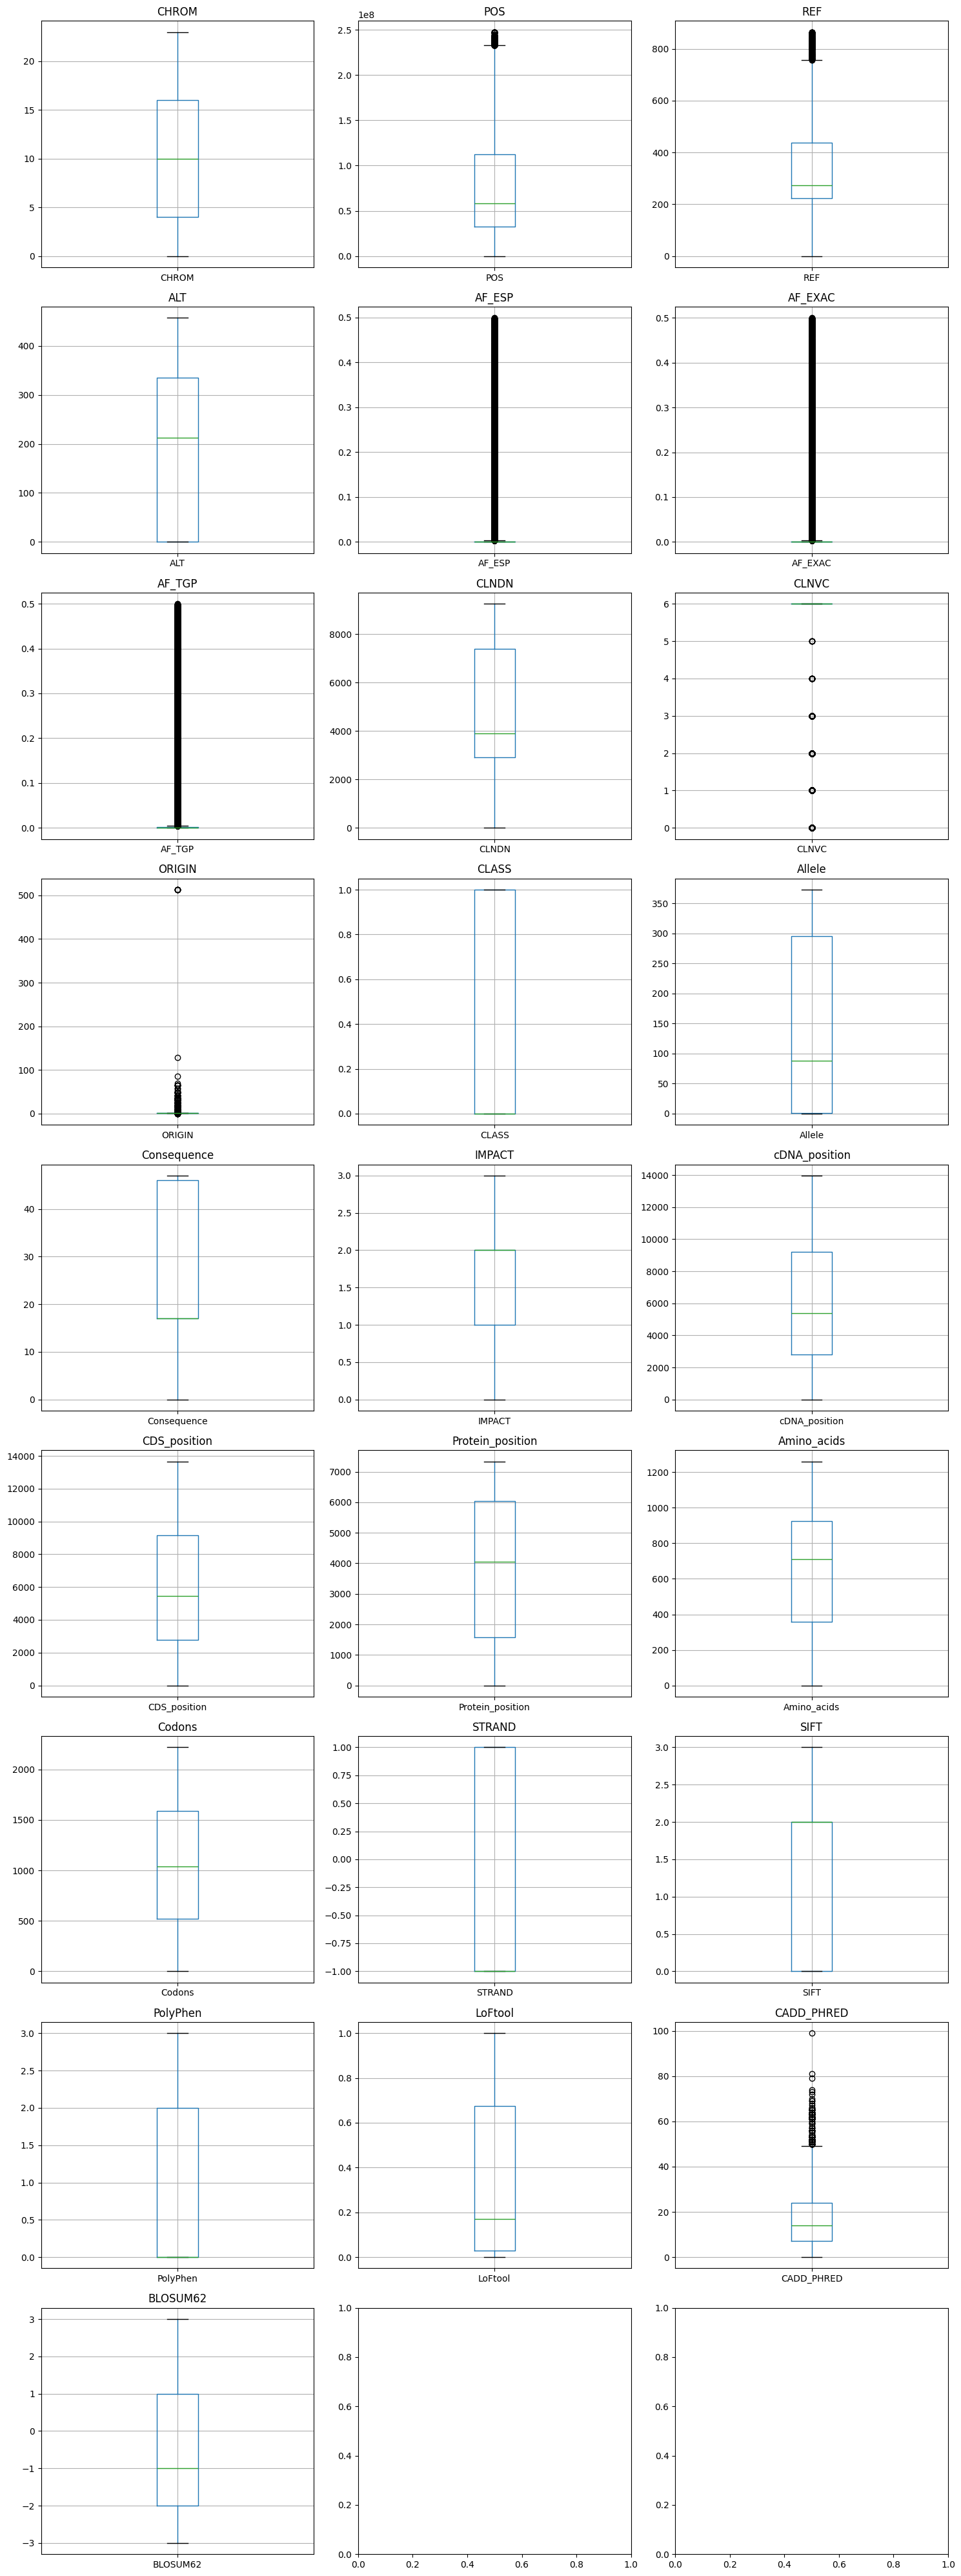

In [ ]:
num_columns = 3
num_rows = (len(df.columns) - 1) // num_columns + 1

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 40))

for i, column in enumerate(df.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row][col]
    df.boxplot(column=column, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()


**Analysis of Allele Frequency (AF) Outliers** The boxplots reveal significant outliers in the three Allele Frequency columns: AF_ESP, AF_EXAC, and AF_TGP. While statistically noisy, these features are highly correlated and biologically critical. They represent the **prevalence** of a variant derived from three distinct large-scale databases:
- ESP: NHLBI Exome Sequencing Project (Disease-focused).
- ExAC: Exome Aggregation Consortium (Large-scale aggregation).
- TGP: 1000 Genomes Project (Global population diversity).
Despite coming from different sources, they measure the same theoretical value. The "outliers" likely represent common polymorphisms (high frequency), whereas the majority of data points represent rare mutations (near-zero frequency), making these distributions essential for distinguishing common variants from pathogenic drivers.

# Data Exploratory Analysis

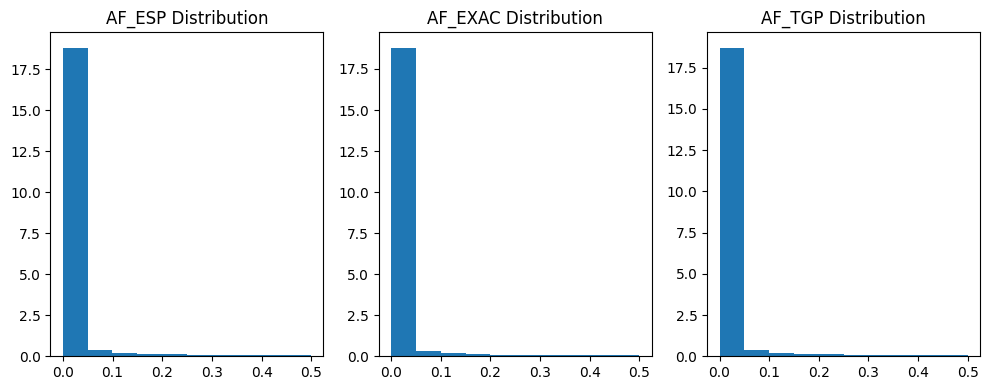

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 4))

ax1.hist(df['AF_ESP'], bins=10, density=True)
ax1.set_title('AF_ESP Distribution')

ax2.hist(df['AF_EXAC'], bins=10, density=True)
ax2.set_title('AF_EXAC Distribution')

ax3.hist(df['AF_TGP'], bins=10, density=True)
ax3.set_title('AF_TGP Distribution')

plt.tight_layout()

plt.show()

While the Allele Frequency columns appear redundant—sharing right-skewed distributions, high correlation, and no reported nulls—this completeness is deceptive. Missing values are encoded as '0', which Python treats as valid data. We must therefore analyze the zero-counts to reveal the true extent of missing data.

In [ ]:
allele_df = df[['AF_ESP', 'AF_EXAC', 'AF_TGP']]

allele_df.info()

# initiate count of three new variables

esp_zeros = 0
exac_zeros = 0
tgp_zeros = 0

# iterate through allele_df and print count of zeroes

for column in allele_df.columns:
    column_values = allele_df[column].values
    zeros_count = len(column_values[column_values == 0])

    if column == 'AF_ESP':
        esp_zeros += zeros_count
    elif column == 'AF_EXAC':
        exac_zeros += zeros_count
    elif column == 'AF_TGP':
        tgp_zeros += zeros_count

print("Count of zeroes (missing values) in AF_ESP column:", esp_zeros)
print("Count of zeroes (missing values) in AF_EXAC column:", exac_zeros)
print("Count of zeroes (missing values) in AF_TGP column:", tgp_zeros)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AF_ESP   65188 non-null  float64
 1   AF_EXAC  65188 non-null  float64
 2   AF_TGP   65188 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB
Count of zeroes (missing values) in AF_ESP column: 35781
Count of zeroes (missing values) in AF_EXAC column: 24047
Count of zeroes (missing values) in AF_TGP column: 37972


In [ ]:
esp_missing = round((esp_zeros / len(allele_df)) * 100, 2)
exac_missing = round((exac_zeros / len(allele_df)) * 100, 2)
tgp_missing = round((tgp_zeros / len(allele_df)) * 100, 2)

print("Percentage of actual missing values in AF_ESP column:", esp_missing)
print("Percentage of actual missing values in AF_EXAC column:", exac_missing)
print("Percentage of actual missing values in AF_TGP column:", tgp_missing)

Percentage of actual missing values in AF_ESP column: 54.89
Percentage of actual missing values in AF_EXAC column: 36.89
Percentage of actual missing values in AF_TGP column: 58.25


All three columns appear to have different counts of zero. Thus, they have different counts of actual null values.

ESP and TGP have similar missing percentages at 54.89 and 58.25, respectively. EXAC, however, has only 36.89 % missing.
The next step is to visualize the distributions after removing null-values.

In [ ]:
for column in allele_df.columns:
    allele_df.loc[allele_df[column] == 0, column] = None

allele_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AF_ESP   29407 non-null  float64
 1   AF_EXAC  41141 non-null  float64
 2   AF_TGP   27216 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB


The 'allele_df' dataframe above now has the correct count of non-null values in each column.

In [ ]:
methods = ['mean', 'median', 'interpolation']

original_skewness = allele_df.skew()

results = {}

for method in methods:
    if method == 'mean':
        filled_df = allele_df.fillna(allele_df.mean())
    elif method == 'median':
        filled_df = allele_df.fillna(allele_df.median())
    elif method == 'interpolation':
        filled_df = allele_df.interpolate()

    # Calculate skewness
    skewness = filled_df.skew()
    results[method] = {'skewness': skewness, }

for method in methods:
    print("Skewness:\n", results[method]['skewness'])
    print()


Skewness:
 AF_ESP     5.202084
AF_EXAC    5.298650
AF_TGP     5.019229
dtype: float64

Skewness:
 AF_ESP     5.487124
AF_EXAC    5.438034
AF_TGP     5.360450
dtype: float64

Skewness:
 AF_ESP     4.116734
AF_EXAC    4.615365
AF_TGP     3.776132
dtype: float64



The skew of the three types of null value filling are above. Interpolation proves to invoke the smallest skew on the data; thus, interpolation will be used for all three columns.

/tmp/ipython-input-4011467777.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  allele_df_boxcox[column].loc[~allele_df_boxcox[column].isna()] = transformed_data


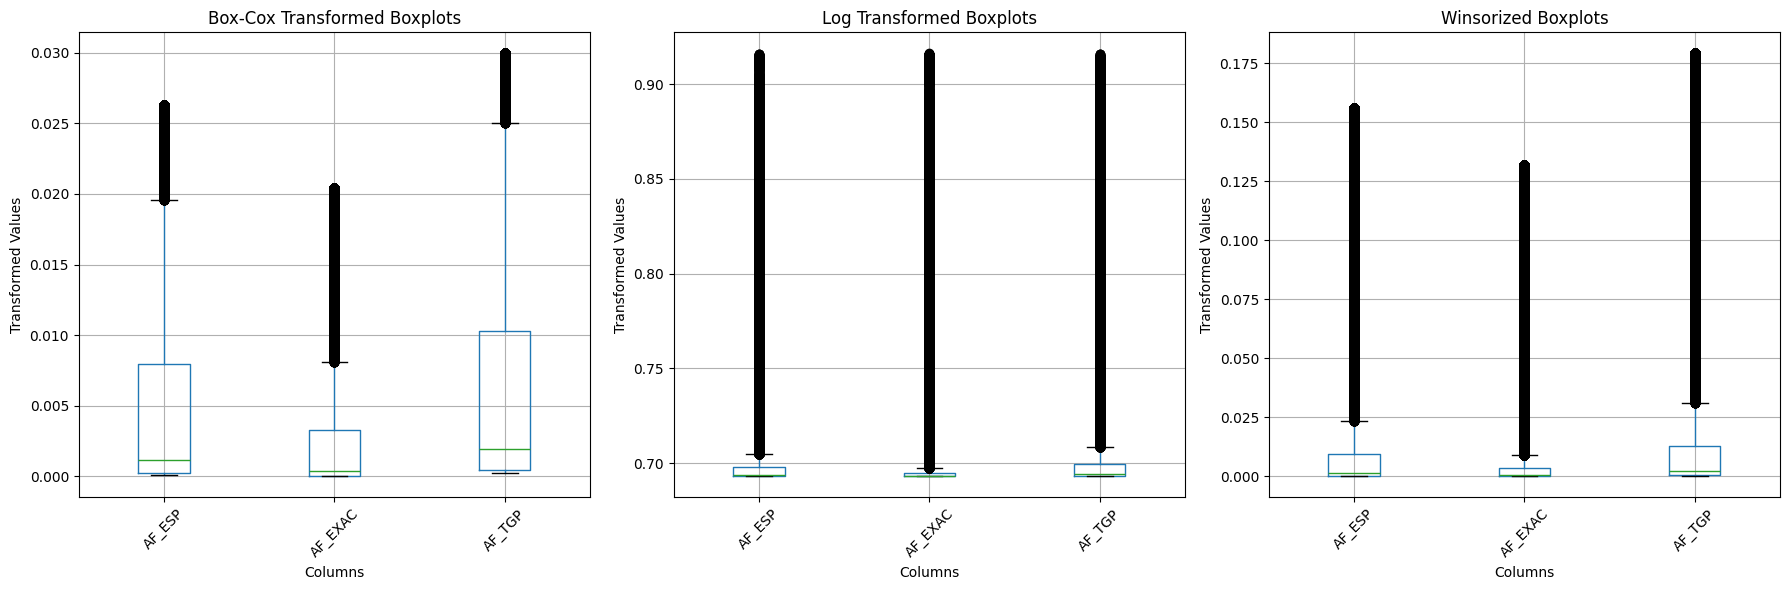

In [ ]:
allele_df = allele_df.interpolate()


allele_df_boxcox = allele_df.copy()
for column in allele_df_boxcox.columns:
    transformed_data, _ = boxcox(allele_df_boxcox[column].dropna() + 1)  # Add 1 to avoid zero values
    allele_df_boxcox[column].loc[~allele_df_boxcox[column].isna()] = transformed_data

log_constant = 1
allele_df_log = np.log1p(allele_df + log_constant)


allele_df_winsorized = allele_df.copy()
for column in allele_df_winsorized.columns:
    allele_df_winsorized[column] = winsorize(allele_df_winsorized[column].dropna(), limits=[0.05, 0.05])


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))


allele_df_boxcox.boxplot(ax=axes[0])
axes[0].set_title("Box-Cox Transformed Boxplots")
axes[0].set_xticklabels(allele_df_boxcox.columns, rotation=45)
axes[0].set_xlabel("Columns")
axes[0].set_ylabel("Transformed Values")


allele_df_log.boxplot(ax=axes[1])
axes[1].set_title("Log Transformed Boxplots")
axes[1].set_xticklabels(allele_df_log.columns, rotation=45)
axes[1].set_xlabel("Columns")
axes[1].set_ylabel("Transformed Values")


allele_df_winsorized.boxplot(ax=axes[2])
axes[2].set_title("Winsorized Boxplots")
axes[2].set_xticklabels(allele_df_winsorized.columns, rotation=45)
axes[2].set_xlabel("Columns")
axes[2].set_ylabel("Transformed Values")


plt.tight_layout()

plt.show()


Clearly from the boxplot representations above we can see that Box-cox transformation transforms the outliers the best.

In [ ]:
df.update(allele_df_boxcox)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  int64  
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  int64  
 3   ALT               65188 non-null  int64  
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  int64  
 8   CLNVC             65188 non-null  int64  
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  int64  
 12  Consequence       65188 non-null  int64  
 13  IMPACT            65188 non-null  int64  
 14  cDNA_position     65188 non-null  int64  
 15  CDS_position      65188 non-null  int64  
 16  Protein_position  65188 non-null  int64 

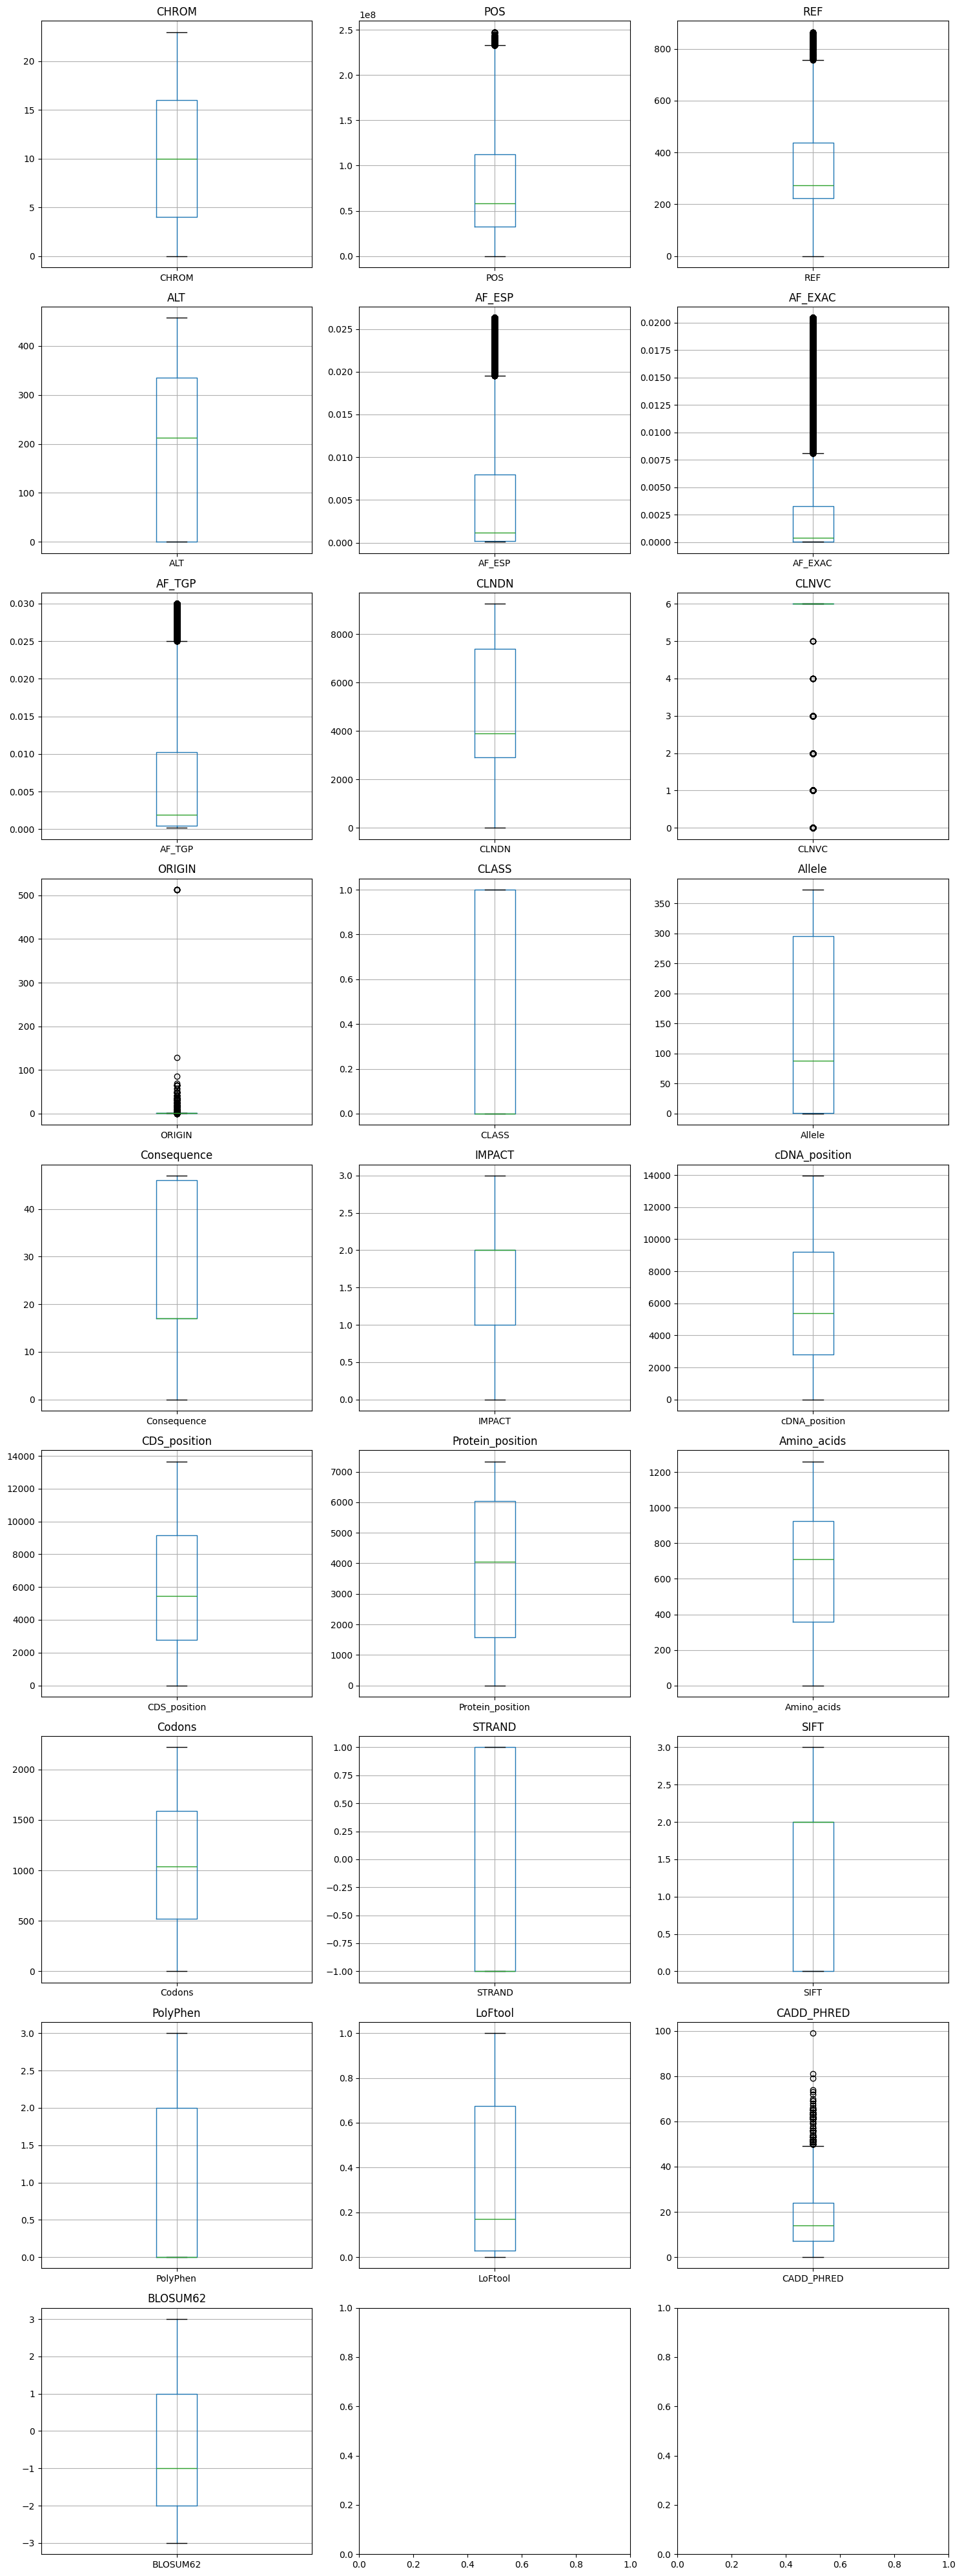

In [ ]:
num_columns = 3
num_rows = (len(df.columns) - 1) // num_columns + 1

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 40))


for i, column in enumerate(df.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row][col]
    df.boxplot(column=column, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

In [ ]:
z_scores = df.apply(stats.zscore)

z_score_threshold = 3
num_outliers = (np.abs(z_scores) > z_score_threshold).sum()

print("Number of Outliers:")
print(num_outliers)


Number of Outliers:
CHROM                  0
POS                    0
REF                    0
ALT                    0
AF_ESP                 0
AF_EXAC                0
AF_TGP                 0
CLNDN                  0
CLNVC               3543
ORIGIN               416
CLASS                  0
Allele                 0
Consequence            0
IMPACT                 0
cDNA_position          0
CDS_position           0
Protein_position       0
Amino_acids            0
Codons                 0
STRAND                 0
SIFT                   0
PolyPhen               0
LoFtool                0
CADD_PHRED           155
BLOSUM62               0
dtype: int64


/tmp/ipython-input-3106686639.py:1: DeprecationWarning: Please import `zscore` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  z_scores = df.apply(stats.zscore)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  int64  
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  int64  
 3   ALT               65188 non-null  int64  
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  int64  
 8   CLNVC             65188 non-null  int64  
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  int64  
 12  Consequence       65188 non-null  int64  
 13  IMPACT            65188 non-null  int64  
 14  cDNA_position     65188 non-null  int64  
 15  CDS_position      65188 non-null  int64  
 16  Protein_position  65188 non-null  int64 

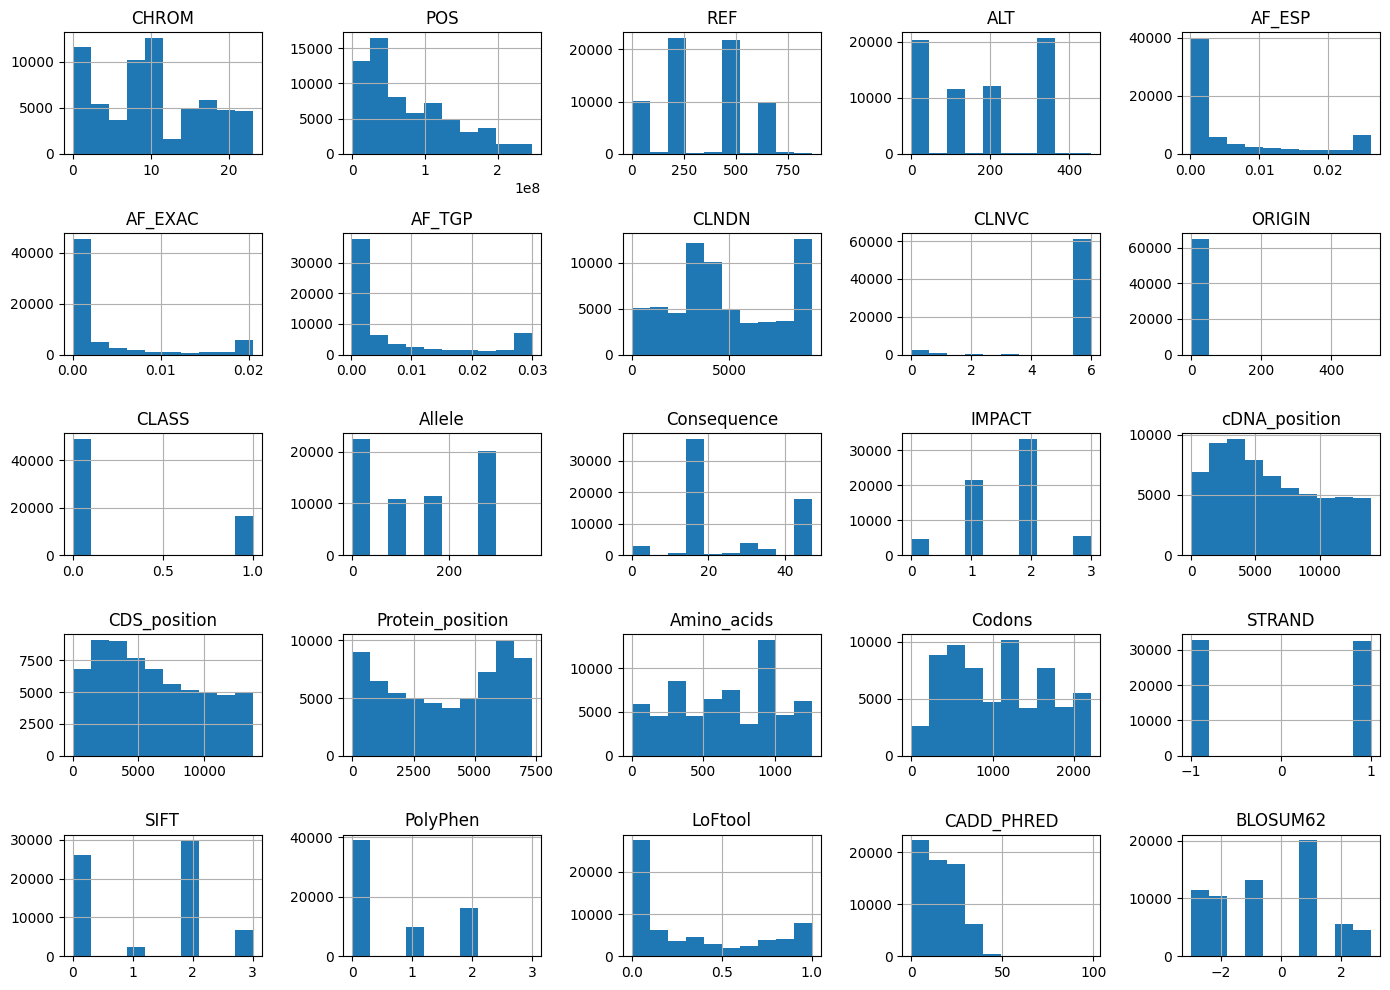

In [ ]:
df.hist(figsize=(14, 10))
plt.tight_layout()
plt.show()

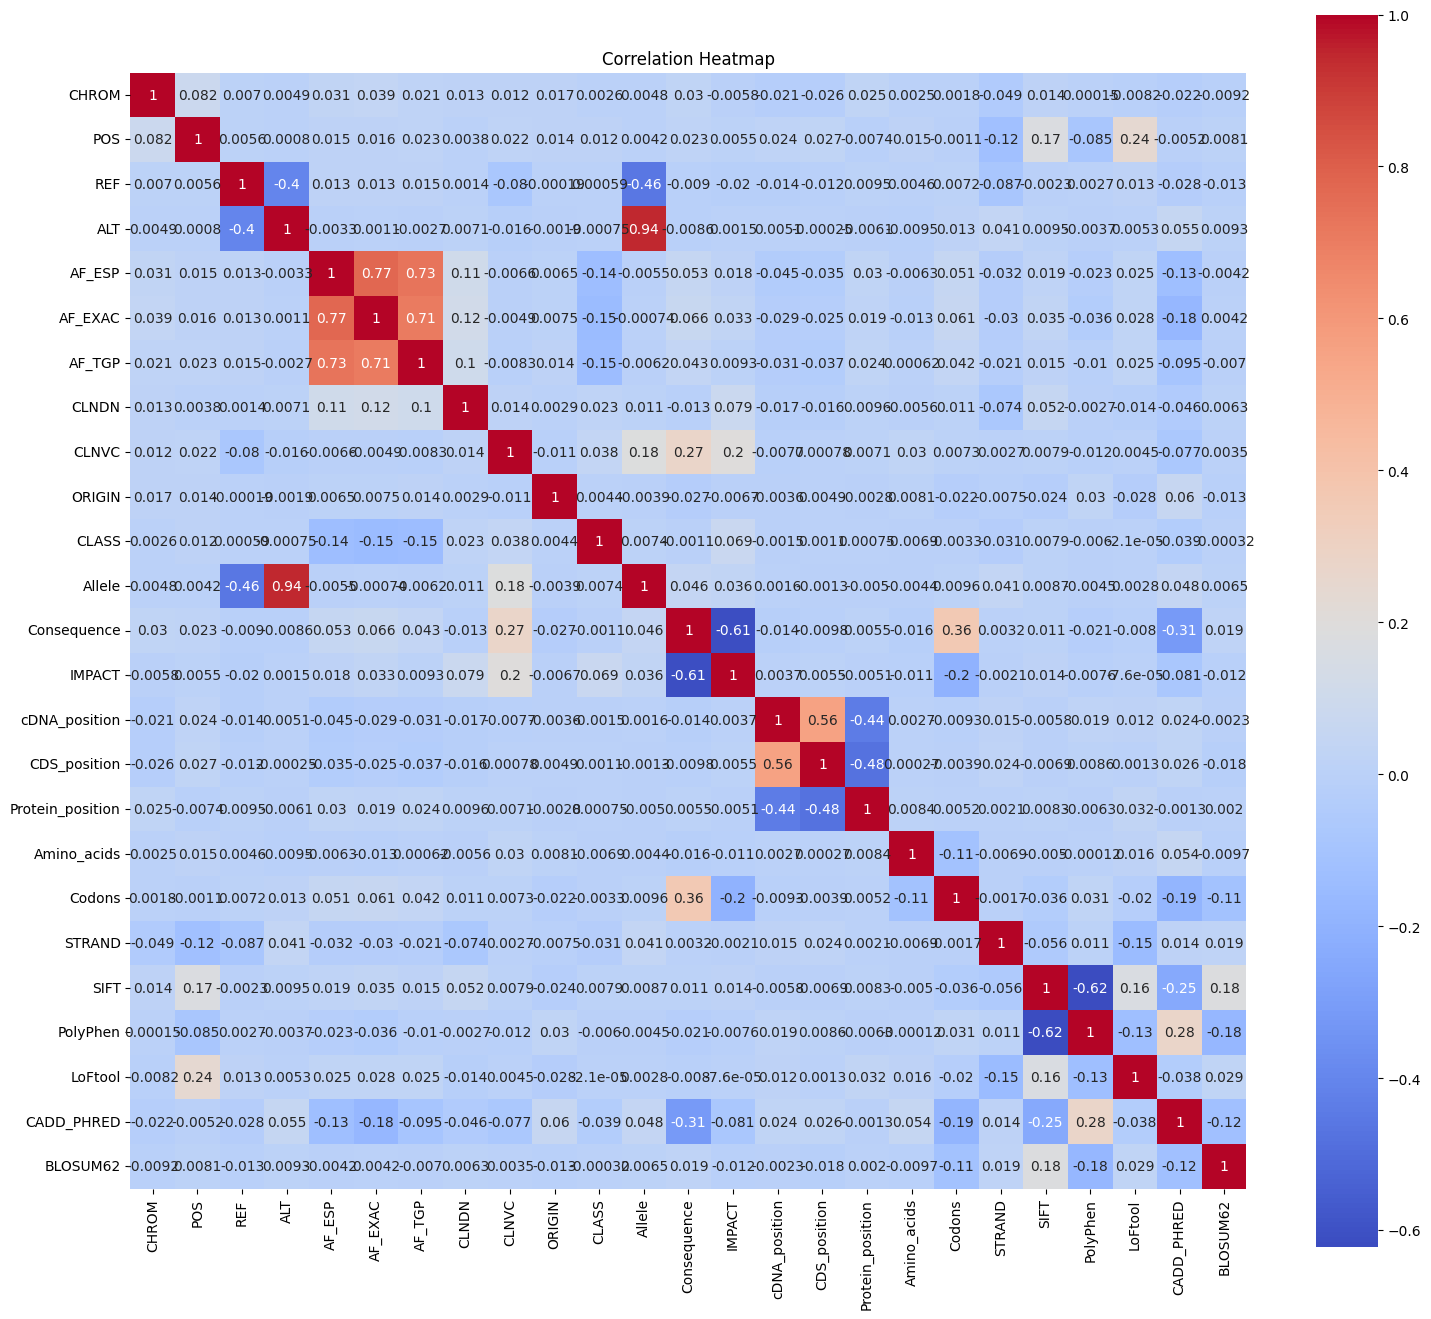

In [ ]:
plt.figure(figsize=(18, 16))

correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)

plt.title('Correlation Heatmap')
plt.show()

The heatmap reveals distinct correlation patterns in the cleaned data. While strong correlations with the target variable suggest high predictive power, high correlations between features indicate potential multicollinearity. To address this trade-off and optimize model stability, we now proceed to Feature Engineering and Feature Selection.

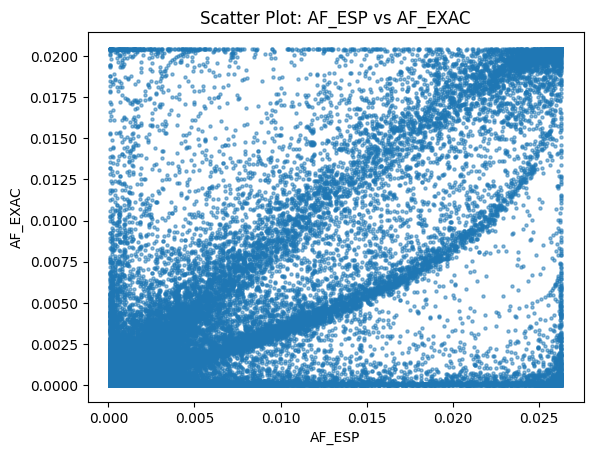

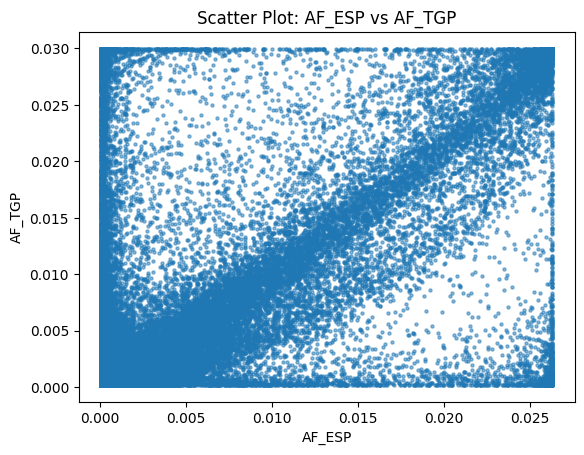

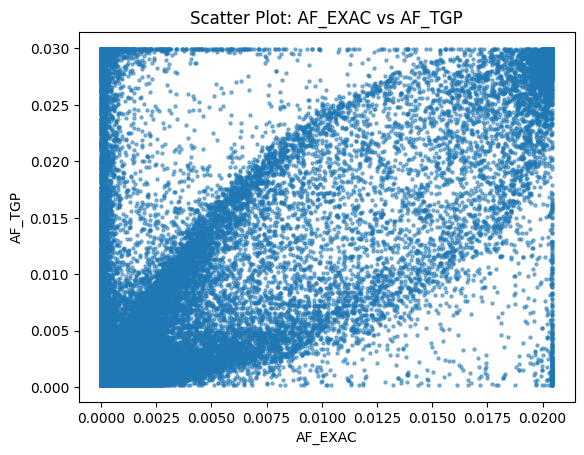

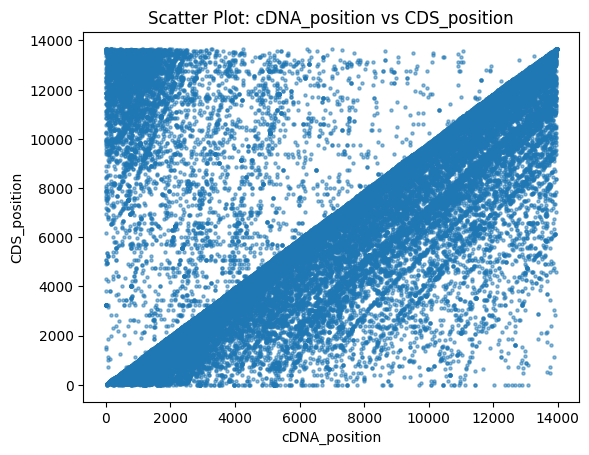

In [ ]:
marker_size = 5
marker_alpha = 0.5

plt.scatter(df['AF_ESP'], df['AF_EXAC'], s=marker_size, alpha=marker_alpha)
plt.xlabel('AF_ESP')
plt.ylabel('AF_EXAC')
plt.title('Scatter Plot: AF_ESP vs AF_EXAC')
plt.show()

plt.scatter(df['AF_ESP'], df['AF_TGP'], s=marker_size, alpha=marker_alpha)
plt.xlabel('AF_ESP')
plt.ylabel('AF_TGP')
plt.title('Scatter Plot: AF_ESP vs AF_TGP')
plt.show()

plt.scatter(df['AF_EXAC'], df['AF_TGP'], s=marker_size, alpha=marker_alpha)
plt.xlabel('AF_EXAC')
plt.ylabel('AF_TGP')
plt.title('Scatter Plot: AF_EXAC vs AF_TGP')
plt.show()

plt.scatter(df['cDNA_position'], df['CDS_position'], s=marker_size, alpha=marker_alpha)
plt.xlabel('cDNA_position')
plt.ylabel('CDS_position')
plt.title('Scatter Plot: cDNA_position vs CDS_position')
plt.show()


# Feature Selection and Model Build

Here we are building model with the target variable being 'CLASS'. it classifies a mutation as pathogenic (Likely Cancer Causing) as 1 and non-pathogenic (Not-cancer cauing) as 0.

In [ ]:
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df.columns[selected_indices]

for feature, score in zip(selected_features, selected_scores):
    print(f"Feature: {feature}, Score: {score}")


Feature: POS, Score: 1.7619275730948203
Feature: AF_ESP, Score: 599.040980221
Feature: AF_EXAC, Score: 804.9076079195974
Feature: AF_TGP, Score: 648.863355896057
Feature: CLNDN, Score: 5.866560144863969
Feature: CLNVC, Score: 4.783730445048191
Feature: Consequence, Score: 35.64629729926267
Feature: Codons, Score: 31.915773252391322
Feature: STRAND, Score: 1.3023152446502215
Feature: LoFtool, Score: 7.283650340902601


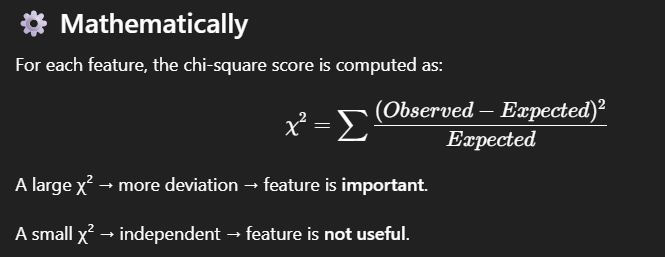

In [ ]:
df['AF_avg'] = (df['AF_ESP'] + df['AF_EXAC'] + df['AF_TGP']) / 3
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  int64  
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  int64  
 3   ALT               65188 non-null  int64  
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  int64  
 8   CLNVC             65188 non-null  int64  
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  int64  
 12  Consequence       65188 non-null  int64  
 13  IMPACT            65188 non-null  int64  
 14  cDNA_position     65188 non-null  int64  
 15  CDS_position      65188 non-null  int64  
 16  Protein_position  65188 non-null  int64 

In [ ]:
corr_class = df[['CLASS', 'AF_avg', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'Consequence',
               'Codons', 'STRAND', 'SIFT', 'LoFtool', 'BLOSUM62']]
corr_class.corr()

,CLASS,AF_avg,AF_ESP,AF_EXAC,AF_TGP,Consequence,Codons,STRAND,SIFT,LoFtool,BLOSUM62
CLASS,1.000000,-0.159273,-0.138132,-0.150996,-0.146407,-0.001063,-0.003259,-0.031191,0.007925,-0.000021,-0.000320
AF_avg,-0.159273,1.000000,0.918308,0.883911,0.915775,0.057413,0.054687,-0.029935,0.023590,0.028154,-0.003477
AF_ESP,-0.138132,0.918308,1.000000,0.772039,0.730739,0.052572,0.050631,-0.032497,0.019265,0.024595,-0.004168
AF_EXAC,-0.150996,0.883911,0.772039,1.000000,0.705108,0.066388,0.061006,-0.030288,0.034660,0.028347,0.004225
AF_TGP,-0.146407,0.915775,0.730739,0.705108,1.000000,0.042794,0.041697,-0.020661,0.014921,0.024678,-0.006967
Consequence,-0.001063,0.057413,0.052572,0.066388,0.042794,1.000000,0.363038,0.003246,0.010925,-0.007989,0.019157
Codons,-0.003259,0.054687,0.050631,0.061006,0.041697,0.363038,1.000000,-0.001692,-0.036368,-0.019975,-0.114815
STRAND,-0.031191,-0.029935,-0.032497,-0.030288,-0.020661,0.003246,-0.001692,1.000000,-0.055874,-0.150199,0.019403
SIFT,0.007925,0.023590,0.019265,0.034660,0.014921,0.010925,-0.036368,-0.055874,1.000000,0.164704,0.181728
LoFtool,-0.000021,0.028154,0.024595,0.028347,0.024678,-0.007989,-0.019975,-0.150199,0.164704,1.000000,0.029392


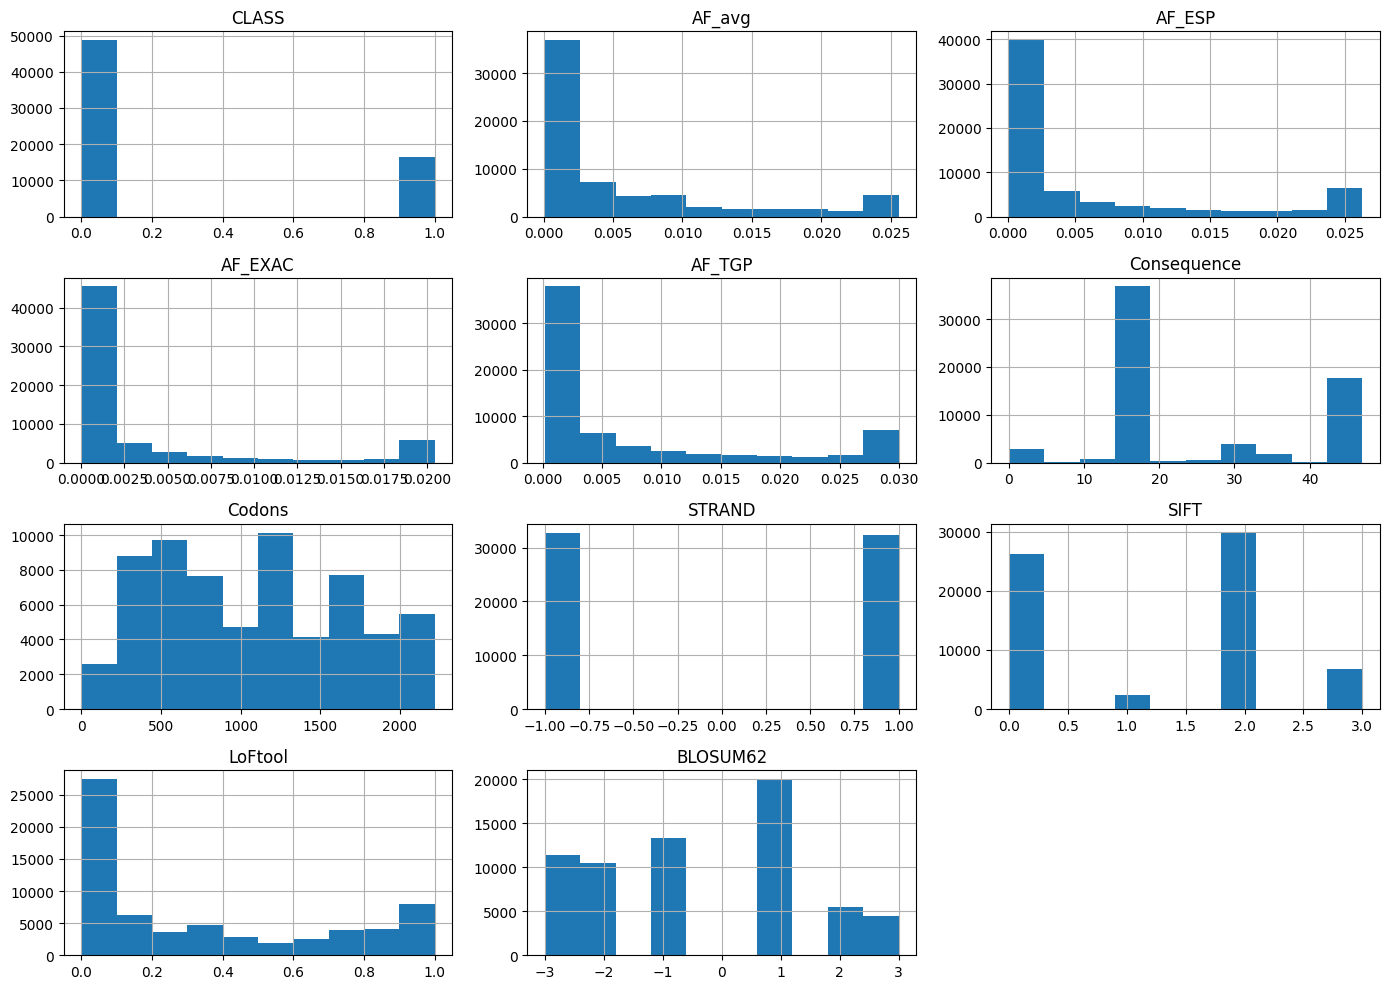

In [ ]:
corr_class.hist(figsize=(14, 10))
plt.tight_layout()
plt.show()

The histogram above displays the distributions of columns within our new 'corr_class' dataframe. This dataframe is a subset of the main 'df' dataframe that contains the selected features from the chi-squared test regarding 'CLASS' as the potential target variable.

#### Principal Component Analysis  [Failed]

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df[['AF_avg', 'AF_ESP', 'AF_EXAC', 'AF_TGP']]

X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=1)
df["pca_1"] = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance.
 [0.86735654]


In [ ]:
df[['AF_avg', 'pca_1', 'AF_ESP', 'AF_EXAC', 'AF_TGP']].corr()

,AF_avg,pca_1,AF_ESP,AF_EXAC,AF_TGP
AF_avg,1.000000,0.999024,0.918308,0.883911,0.915775
pca_1,0.999024,1.000000,0.920048,0.902327,0.900385
AF_ESP,0.918308,0.920048,1.000000,0.772039,0.730739
AF_EXAC,0.883911,0.902327,0.772039,1.000000,0.705108
AF_TGP,0.915775,0.900385,0.730739,0.705108,1.000000


In [ ]:
df_new = df.copy()

# Drop the specified columns
df_new.drop(['AF_ESP', 'AF_EXAC', 'AF_avg', 'AF_TGP'], axis=1, inplace=True)

X = df_new.drop('CLASS', axis=1)
y = df_new['CLASS']

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df_new.columns[selected_indices]

for feature, score in zip(selected_features, selected_scores):
    print(f"Feature: {feature}, Score: {score}")


Feature: POS, Score: 1.7619275730948203
Feature: CLNDN, Score: 5.866560144863969
Feature: CLNVC, Score: 4.783730445048191
Feature: CLASS, Score: 1.0476288731686982
Feature: Consequence, Score: 35.64629729926267
Feature: Codons, Score: 31.915773252391322
Feature: STRAND, Score: 1.3023152446502215
Feature: SIFT, Score: 0.8762792690766462
Feature: LoFtool, Score: 7.283650340902601
Feature: BLOSUM62, Score: 672.3017197715799


Performing a chi-squared test proves that the 'pca_1' variable is not a good feature for the model. Let's explore a bit more.

In [ ]:
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df.columns[selected_indices]

for feature, score in zip(selected_features, selected_scores):
    print(f"Feature: {feature}, Score: {score}")


Feature: AF_ESP, Score: 599.040980221
Feature: AF_EXAC, Score: 804.9076079195974
Feature: AF_TGP, Score: 648.863355896057
Feature: CLNDN, Score: 5.866560144863969
Feature: CLNVC, Score: 4.783730445048191
Feature: Consequence, Score: 35.64629729926267
Feature: Codons, Score: 31.915773252391322
Feature: LoFtool, Score: 7.283650340902601
Feature: BLOSUM62, Score: 664.3200865245467
Feature: AF_avg, Score: 672.3017197715799


#### Using AF_AVG instead

Chi-squared test confirms that Allele Frequency features are significant predictors. However, given their strong inter-correlation (multicollinearity), retaining all three source columns is redundant. To preserve this critical biological signal while ensuring model stability, we select the aggregated AF_avg feature and drop the individual components

In [ ]:
df_three = df.copy()
df_three.drop(['AF_ESP', 'AF_TGP', 'AF_EXAC'], axis=1, inplace=True)

X = df_three.drop('CLASS', axis=1)
y = df['CLASS']

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df_three.columns[selected_indices]

for feature, score in zip(selected_features, selected_scores):
    print(f"Feature: {feature}, Score: {score}")


Feature: POS, Score: 1.7619275730948203
Feature: CLNDN, Score: 5.866560144863969
Feature: CLNVC, Score: 4.783730445048191
Feature: CLASS, Score: 1.0476288731686982
Feature: Consequence, Score: 35.64629729926267
Feature: Codons, Score: 31.915773252391322
Feature: STRAND, Score: 1.3023152446502215
Feature: LoFtool, Score: 7.283650340902601
Feature: BLOSUM62, Score: 664.3200865245467
Feature: AF_avg, Score: 672.3017197715799


In [ ]:
X_new.shape

(65188, 10)

# Applying ML and DL models on the Final Processed Dataset

# Logistic Regression

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Create and fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = logreg.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.7491946617579384
Precision: 0.7491946617579384
Recall: 0.7491946617579384
F1 Score: 0.7491946617579384
Confusion Matrix:
[[9768    0]
 [3270    0]]


In [ ]:
unique_values, counts = np.unique(y, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 48754
1: 16434


### **Solution**: Logistic Regression with scaling + Balancing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

## Logistic Regression (Needs Scaling + Balancing)

# Scaling for Logistic Regression!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize with class_weight='balanced'
# This forces the model to pay 3x more attention to the minority class
logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)

print("--- Logistic Regression Results ---")
y_pred_log = logreg.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

--- Logistic Regression Results ---
[[4316 5452]
 [ 844 2426]]
              precision    recall  f1-score   support

           0       0.84      0.44      0.58      9768
           1       0.31      0.74      0.44      3270

    accuracy                           0.52     13038
   macro avg       0.57      0.59      0.51     13038
weighted avg       0.70      0.52      0.54     13038



### Here Recall (0.74 for Class 1) <--- The most important Metric for us
as it says Out of all the actual cancer cases in the dataset, how many did we find? = 74%

Accuracy of the logistic regression model after chi-squared feature selection has an accuracy of 0.749. Unfortunately, the confusion matrix, precision, and recall score prove that the model is not good at capturing the relationship between the target and features. Let's try Lasso now.

## Random Forest

In [ ]:
# Random Forest doesn't strictly need scaling, but does need balancing
rf = RandomForestClassifier(n_estimators=100,
                            class_weight='balanced',
                            random_state=42)
rf.fit(X_train, y_train)

print("--- Random Forest Results ---")
y_pred_rf = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

--- Random Forest Results ---
[[9238  530]
 [2625  645]]
              precision    recall  f1-score   support

           0       0.78      0.95      0.85      9768
           1       0.55      0.20      0.29      3270

    accuracy                           0.76     13038
   macro avg       0.66      0.57      0.57     13038
weighted avg       0.72      0.76      0.71     13038



Clearly Random forest has higher Accuracy than the Linear Regression but in reality this accuracy again is **missleading** as the recall for the cancer class is droped to **22%**!

### Solution
This problem arises in random forest result is due to it takes decision based on 50% probabilty
- if probability of cancer > 50 -> it says cancer
- else benign <br/>
In our case we should drop the threshold much lower to 30% so that even if the probabilty of cancer > 30% we should mark it cancer in random forest prediction

In [ ]:
# Get the probabilities instead of just True/False
y_prob = rf.predict_proba(X_test)[:, 1]

# 2. Setting a lower threshold (30% instead of 50%)
# If the model is even  30% suspicious, we label it as Cancer (1)
custom_threshold = 0.30
y_pred_adjusted = (y_prob >= custom_threshold).astype(int)


print(f"--- Random Forest with Threshold {custom_threshold} ---")
print(confusion_matrix(y_test, y_pred_adjusted))
print(classification_report(y_test, y_pred_adjusted))

--- Random Forest with Threshold 0.3 ---
[[7044 2724]
 [1168 2102]]
              precision    recall  f1-score   support

           0       0.86      0.72      0.78      9768
           1       0.44      0.64      0.52      3270

    accuracy                           0.70     13038
   macro avg       0.65      0.68      0.65     13038
weighted avg       0.75      0.70      0.72     13038



In [ ]:
# Get the probabilities instead of just True/False
y_prob = rf.predict_proba(X_test)[:, 1]

# 2. Setting a lower threshold (30% instead of 50%)
# If the model is even  30% suspicious, we label it as Cancer (1)
custom_threshold = 0.10
y_pred_adjusted = (y_prob >= custom_threshold).astype(int)


print(f"--- Random Forest with Threshold {custom_threshold} ---")
print(confusion_matrix(y_test, y_pred_adjusted))
print(classification_report(y_test, y_pred_adjusted))

--- Random Forest with Threshold 0.1 ---
[[3038 6730]
 [ 167 3103]]
              precision    recall  f1-score   support

           0       0.95      0.31      0.47      9768
           1       0.32      0.95      0.47      3270

    accuracy                           0.47     13038
   macro avg       0.63      0.63      0.47     13038
weighted avg       0.79      0.47      0.47     13038



Here more we decrease the threshold we acheived greater recall sacrificing the accuracy so the question is where to draw the line and choose final optimal threshold.

We will take the help of the f1 sscore to get the peak thershold where Precision and Recall are best balanced

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# 1. Get the probabilities for the positive class (Cancer)
y_scores = rf.predict_proba(X_test)[:, 1]

# 2. Test thresholds from 0.01 to 1.00
thresholds = np.arange(0.01, 1.0, 0.01)
f1_scores = []

for t in thresholds:
    # Convert probabilities to 0 or 1 based on current threshold t
    y_pred_temp = (y_scores >= t).astype(int)
    # Calculate F1 score for the Cancer class (1)
    score = f1_score(y_test, y_pred_temp)
    f1_scores.append(score)

# 3. Find the best one
best_threshold = thresholds[np.argmax(f1_scores)]
max_f1 = max(f1_scores)

print(f"The Best Mathematical Threshold is: {best_threshold}")
print(f"Maximum F1 Score: {max_f1}")

The Best Mathematical Threshold is: 0.26
Maximum F1 Score: 0.5220368938473433


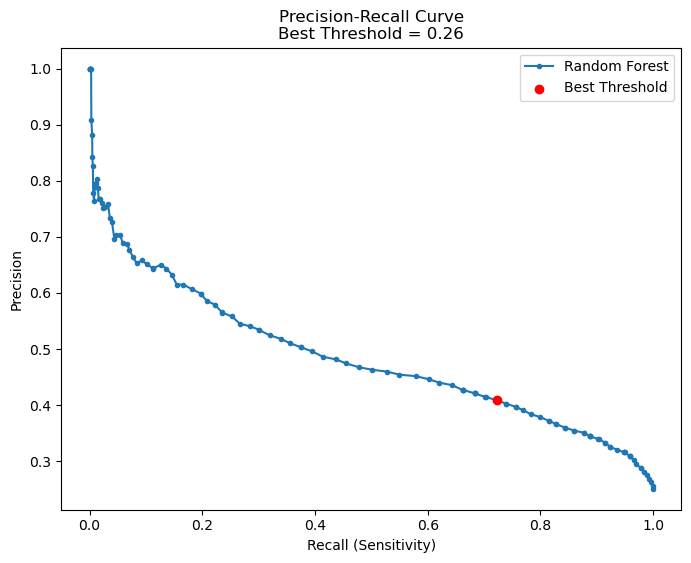

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_scores)


f1_scores_pr = 2 * (precisions * recalls) / (precisions + recalls)
# Locate the best F1
best_idx = np.argmax(f1_scores_pr)

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.', label='Random Forest')
plt.scatter(recalls[best_idx], precisions[best_idx], marker='o', color='red', label='Best Threshold', zorder=10)
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve\nBest Threshold = {thresholds_pr[best_idx]:.2f}')
plt.legend()
plt.show()

In [ ]:
# Get the probabilities instead of just True/False
y_prob = rf.predict_proba(X_test)[:, 1]

custom_threshold = 0.26
y_pred_adjusted = (y_prob >= custom_threshold).astype(int)


print(f"--- Random Forest with Threshold {custom_threshold} ---")
print(confusion_matrix(y_test, y_pred_adjusted))
print(classification_report(y_test, y_pred_adjusted))

--- Random Forest with Threshold 0.26 ---
[[6348 3420]
 [ 907 2363]]
              precision    recall  f1-score   support

           0       0.87      0.65      0.75      9768
           1       0.41      0.72      0.52      3270

    accuracy                           0.67     13038
   macro avg       0.64      0.69      0.63     13038
weighted avg       0.76      0.67      0.69     13038



So here we achived achived greater weighted accuracy (69%) over the logistic on almost same recall value on class 1 (cancer postive mutation)

# Boosting Algorithms

In [ ]:
import numpy as np
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix

count_neg = np.sum(y_train == 0)
count_pos = np.sum(y_train == 1)
scale_ratio = count_neg / count_pos

print(f"Negatives: {count_neg}, Positives: {count_pos}")
print(f"XGBoost Scale Ratio: {scale_ratio:.2f}")
print("\n" + "\n")

xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=scale_ratio,  # Forces model to care about the minority class
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)

print("--- XGBoost Results ---")
y_pred_xgb = xgb.predict(X_test)
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Negatives: 38986, Positives: 13164
XGBoost Scale Ratio: 2.96




/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


--- XGBoost Results ---
[[6138 3630]
 [ 804 2466]]
              precision    recall  f1-score   support

           0       0.88      0.63      0.73      9768
           1       0.40      0.75      0.53      3270

    accuracy                           0.66     13038
   macro avg       0.64      0.69      0.63     13038
weighted avg       0.76      0.66      0.68     13038



In [ ]:
# LightGBM is faster and often handles categorical features better.
lgbm = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    class_weight='balanced', # fix for imbalance
    random_state=42,
    verbosity=-1 # Silences warning logs
)

lgbm.fit(X_train, y_train)

print("--- LightGBM Results ---")
y_pred_lgbm = lgbm.predict(X_test)
print(confusion_matrix(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))

--- LightGBM Results ---
[[6207 3561]
 [ 824 2446]]
              precision    recall  f1-score   support

           0       0.88      0.64      0.74      9768
           1       0.41      0.75      0.53      3270

    accuracy                           0.66     13038
   macro avg       0.64      0.69      0.63     13038
weighted avg       0.76      0.66      0.69     13038



In [ ]:
## Tuning XGBoost
from sklearn.model_selection import RandomizedSearchCV

xgb_params = {
    'n_estimators': [100, 200, 300],          # How many trees?
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # How fast to learn? (Lower is usually better but slower)
    'max_depth': [3, 5, 6, 10],               # How deep is each tree? (Too deep = Overfitting)
    'subsample': [0.6, 0.8, 1.0],             # Use only % of data rows per tree
    'colsample_bytree': [0.6, 0.8, 1.0],      # Use only % of columns per tree
    'scale_pos_weight': [scale_ratio]         # KEEP THIS FIXED (Your imbalance ratio)
}

# Initialize the Base Model
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Setup the Search (Try 20 random combinations)
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_params,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Tuning XGBoost... This may take a minute.")
xgb_search.fit(X_train, y_train)

print(f"Best XGBoost Params: {xgb_search.best_params_}")
best_xgb = xgb_search.best_estimator_

print("\n--- Optimized XGBoost Results ---")
y_pred_opt_xgb = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred_opt_xgb))

Tuning XGBoost... This may take a minute.
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarnin

Best XGBoost Params: {'subsample': 0.6, 'scale_pos_weight': 2.9615618353084168, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.6}

--- Optimized XGBoost Results ---
              precision    recall  f1-score   support

           0       0.88      0.66      0.75      9768
           1       0.42      0.74      0.54      3270

    accuracy                           0.68     13038
   macro avg       0.65      0.70      0.64     13038
weighted avg       0.77      0.68      0.70     13038



In [ ]:
from lightgbm import LGBMClassifier

lgbm_params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 50, 100],      # Key parameter for LightGBM complexity
    'max_depth': [-1, 10, 20],            # -1 means no limit (rely on num_leaves)
    'min_child_samples': [20, 50, 100],   # Prevent overfitting on small leaf nodes
    'class_weight': ['balanced']          # KEEP THIS FIXED
}

# Initialize Base Model
lgbm = LGBMClassifier(random_state=42, verbosity=-1)

# Setup Search
lgbm_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_params,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Tuning LightGBM...")
lgbm_search.fit(X_train, y_train)

print(f"Best LightGBM Params: {lgbm_search.best_params_}")
best_lgbm = lgbm_search.best_estimator_

print("\n--- Optimized LightGBM Results ---")
y_pred_opt_lgbm = best_lgbm.predict(X_test)
print(classification_report(y_test, y_pred_opt_lgbm))

Tuning LightGBM...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best LightGBM Params: {'num_leaves': 20, 'n_estimators': 500, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.05, 'class_weight': 'balanced'}

--- Optimized LightGBM Results ---
              precision    recall  f1-score   support

           0       0.88      0.65      0.75      9768
           1       0.41      0.74      0.53      3270

    accuracy                           0.67     13038
   macro avg       0.65      0.69      0.64     13038
weighted avg       0.76      0.67      0.69     13038



# SVM & KNN

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

print("Training SVM... ")

# kernel='rbf' allows it to learn non-linear (curved) boundaries
# probability=True is REQUIRED to tune thresholds later
# class_weight='balanced' is REQUIRED for your imbalance
svm_model = SVC(kernel='rbf',
                class_weight='balanced',
                probability=True,
                random_state=42)

svm_model.fit(X_train_scaled, y_train)

print("--- SVM Results ---")
y_pred_svm = svm_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred_svm))




Training SVM... 
--- SVM Results ---
              precision    recall  f1-score   support

           0       0.86      0.48      0.61      9768
           1       0.33      0.77      0.46      3270

    accuracy                           0.55     13038
   macro avg       0.59      0.62      0.54     13038
weighted avg       0.73      0.55      0.58     13038



In [ ]:
print("Training KNN...")

# weights='distance': Closer neighbors count more than far ones (Helps with imbalance!)
# n_neighbors=5: Standard starting point
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')

knn_model.fit(X_train_scaled, y_train)

print("--- KNN Results ---")
y_pred_knn = knn_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred_knn))

Training KNN...
--- KNN Results ---
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      9768
           1       0.39      0.27      0.32      3270

    accuracy                           0.71     13038
   macro avg       0.59      0.57      0.57     13038
weighted avg       0.68      0.71      0.69     13038



# Deep Learning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# B. Convert Numpy Arrays to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# batch_size=32
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

Using device: cuda


In [ ]:
class CancerClassifier(nn.Module):
    def __init__(self, input_dim):
        super(CancerClassifier, self).__init__()

        # BLOCK 1: Expansion (Input -> 128)
        self.layer1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)       # <--- NEW: Stabilizes training
        self.act1 = nn.LeakyReLU(negative_slope=0.01) # <--- NEW: Prevents dead neurons
        self.drop1 = nn.Dropout(0.2)         # <--- REDUCED: Don't kill too much signal

        # BLOCK 2: Compression (128 -> 64)
        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.act2 = nn.LeakyReLU(negative_slope=0.01)
        self.drop2 = nn.Dropout(0.2)

        # BLOCK 3: Refinement (64 -> 32)
        self.layer3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.act3 = nn.LeakyReLU(negative_slope=0.01)

        # Output
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        # Block 1
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.drop1(x)

        # Block 2
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.drop2(x)

        # Block 3
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.act3(x)

        # Output
        x = self.output(x)
        return x



input_dim = X_train_scaled.shape[1]
model = CancerClassifier(input_dim).to(device)

In [ ]:
# Number of Negatives / Number of Positives
num_neg = np.sum(y_train == 0)
num_pos = np.sum(y_train == 1)
pos_weight_value = num_neg / num_pos
pos_weight_tensor = torch.tensor(pos_weight_value, dtype=torch.float32).to(device)

print(f"Calculated pos_weight: {pos_weight_value:.2f}")

# Loss Function: BCEWithLogitsLoss handles Sigmoid internally + Class Imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Calculated pos_weight: 2.96


Starting PyTorch Training...
Epoch [10/500], Loss: 0.8696
Epoch [20/500], Loss: 0.8695
Epoch [30/500], Loss: 0.8675
Epoch [40/500], Loss: 0.8664
Epoch [50/500], Loss: 0.8691
Epoch [60/500], Loss: 0.8676
Epoch [70/500], Loss: 0.8729
Epoch [80/500], Loss: 0.8703
Epoch [90/500], Loss: 0.8679
Epoch [100/500], Loss: 0.8718
Epoch [110/500], Loss: 0.8666
Epoch [120/500], Loss: 0.8654
Epoch [130/500], Loss: 0.8718
Epoch [140/500], Loss: 0.8678
Epoch [150/500], Loss: 0.8696
Epoch [160/500], Loss: 0.8677
Epoch [170/500], Loss: 0.8684
Epoch [180/500], Loss: 0.8665
Epoch [190/500], Loss: 0.8689
Epoch [200/500], Loss: 0.8701
Epoch [210/500], Loss: 0.8683
Epoch [220/500], Loss: 0.8664
Epoch [230/500], Loss: 0.8709
Epoch [240/500], Loss: 0.8692
Epoch [250/500], Loss: 0.8675
Epoch [260/500], Loss: 0.8646
Epoch [270/500], Loss: 0.8677
Epoch [280/500], Loss: 0.8638
Epoch [290/500], Loss: 0.8698
Epoch [300/500], Loss: 0.8651
Epoch [310/500], Loss: 0.8664
Epoch [320/500], Loss: 0.8656
Epoch [330/500], Los

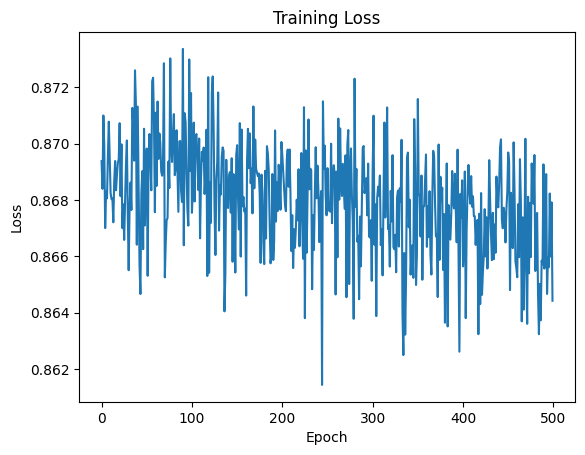

In [ ]:
epochs = 500
train_losses = []

print("Starting PyTorch Training...")

for epoch in range(epochs):
    model.train() # Set model to training mode (enables Dropout)
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
model.eval()

with torch.no_grad():
    y_logits = model(X_test_tensor)
    y_probs = torch.sigmoid(y_logits).cpu().numpy()
    y_pred_pytorch = (y_probs >= 0.5).astype(int)

print("\n--- PyTorch Model Results ---")
print(confusion_matrix(y_test, y_pred_pytorch))
print(classification_report(y_test, y_pred_pytorch))


--- PyTorch Model Results ---
[[5788 3980]
 [ 895 2375]]
              precision    recall  f1-score   support

           0       0.87      0.59      0.70      9768
           1       0.37      0.73      0.49      3270

    accuracy                           0.63     13038
   macro avg       0.62      0.66      0.60     13038
weighted avg       0.74      0.63      0.65     13038



The mean squared error (MSE) value of 3.009 indicates that, on average, the predicted values from the XGBoost regression model deviate from the actual values by approximately 3.009 units squared. A lower MSE indicates better model performance, with a value of 0 indicating a perfect fit.

The R-squared (R2) value of 0.945 suggests that approximately 94.5% of the variance in the target variable ('cDNA_position') can be explained by the selected features and the XGBoost regression model. R2 ranges from 0 to 1, with a higher value indicating a better fit. An R2 value close to 1 indicates that the model captures most of the variance in the target variable.

In summary, the XGBoost regression model with the selected features demonstrates strong performance with a low MSE and high R2 value, indicating accurate predictions and a good fit to the data.

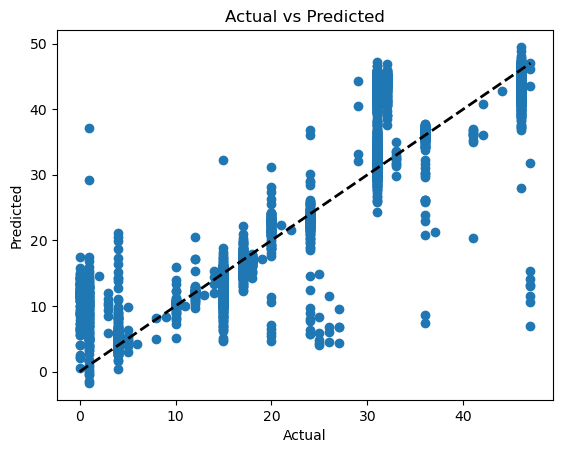

In [ ]:
# Create a plot of actual vs predicted values
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

/tmp/ipykernel_34/2536707525.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label='Actual', color='g', shade=True, linewidth=3)
/tmp/ipykernel_34/2536707525.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred, label='Predicted', color='r', shade=True, linewidth=3)


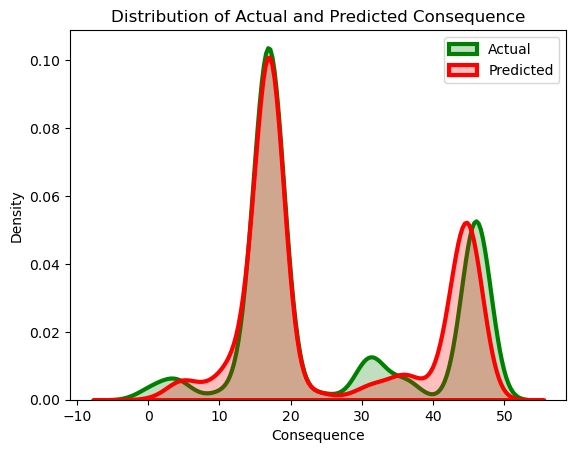

In [ ]:
# Create a plot of the distribution of predicted values
sns.kdeplot(y_test, label='Actual', color='g', shade=True, linewidth=3)
sns.kdeplot(y_pred, label='Predicted', color='r', shade=True, linewidth=3)
plt.xlabel('Consequence')
plt.ylabel('Density')
plt.title('Distribution of Actual and Predicted Consequence')
plt.legend()
plt.show()

In summary, a few conclusions can be made from the various models I've built.
1. The allele frequency columns are significantly different
2. Logistic Regression, RFE, and XGBoost performed similarly at predicting 'CLASS' - R2 score was 0.77
3. XGBoost worked best at predicting both 'PolyPhen' and 'Consequence', providing R2 scores of 0.76 and 0.94, respectively.
4. Each model selected different features during the feature selection process, but variables such as the three allele frequency columns, cDNA_position, LoFtool, SIFT, BLOSUM62, and a few others were frequently selected.
5. There are a multitude of experiments that can extend off of this first one. Stay tuned!